In [11]:
import numpy as np
import tkinter as tk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from ipywidgets import interact, FloatSlider, VBox, HBox, interactive_output, ToggleButton, Layout

def system(variables, r, t_param = None):
    x, y = variables
    dxdt = r*x - x**3 - y
    if t_param is None:
        dydt = x - y
    else:
        dydt = (1/t_param) * (x - y)
    return [dxdt, dydt]

def stability(point, r, t=None):
    if t is None:
        jacobian_matrix = np.array([[r - 3*point**2, -1],
                                     [1, -1]])
    else:
        jacobian_matrix = np.array([[r - 3*point**2, -1],
                                     [1/t, -1/t]])      
    
    # Calculate the eigenvalues of the Jacobian matrix
    eigenvalues = np.linalg.eigvals(jacobian_matrix)
    
    # Determine the stability based on the eigenvalues
    if all(eigenvalues.imag == 0): # means are real:
        if all(eigenvalues.real < 0):
            return "Stable node"
        elif all(eigenvalues.real > 0):
            return "Unstable node"
        elif any(eigenvalues.real > 0) and any(eigenvalues.real < 0):
            return "Saddle point"
    else:
        if all(eigenvalues.real < 0):
            return "Stable spiral"
        elif all(eigenvalues.real > 0):
            return "Unstable spiral"
        elif all(eigenvalues.real == 0):
            return "Centre"        

def trace_det(point, r, t = None):
    if t is None:
        jacobian_matrix = np.array([[r - 3*point**2, -1],
                                     [1, -1]])
    else:
        jacobian_matrix = np.array([[r - 3*point**2, -1],
                                     [1/t, -1/t]])        
    # Calculate the eigenvalues of the Jacobian matrix
    eigenvalues = np.linalg.eigvals(jacobian_matrix)
    determinant = 1
    trace = 0
    for value in eigenvalues:
        determinant *= value
        trace += value
    return [determinant, trace]
    

def plot_phase_portrait(axs, zoom_val = 1, arrow_flow = 20,
                        r=3, time_span = 1, x_start=0.3, y_start=1, 
                        use_custom_t=True, t_param=1.0):
    # Clear previous plot
    axs[0].cla()
    axs[1].cla()
    
    # Define parameters
    t_param_value = t_param if use_custom_t else None
    
    x_range = np.linspace(-3, 3, 100)
    y_range_1 = r * x_range - x_range ** 3
    y_range_2 = x_range
    axs[0].plot(x_range, y_range_1, label='dx/dt = r*x - x^3 - y')
    axs[0].plot(x_range, y_range_2, label='dy/dt = x - y')

    inter_1 = 0
    
    axs[0].plot(inter_1, inter_1, 'o', color='cyan')
    axs[0].annotate(stability(point=inter_1, r=r, t=t_param_value), (inter_1, inter_1), textcoords="offset points", 
                 xytext=(inter_1+4, inter_1+20), ha='center', fontsize=10,
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='blue', facecolor='white'),
                 arrowprops=dict(arrowstyle='-', color='black'))
    
    values_1 = trace_det(point=inter_1, r=r, t=t_param_value)
    axs[1].plot(values_1[0], values_1[1], 'o')
    
    if r >= 1:
        inter_2 = np.sqrt(r-1)
        inter_3 = - inter_2
        axs[0].plot(inter_2, inter_2, 'o', color='cyan')

        axs[0].annotate(stability(point=inter_2, r=r, t=t_param_value), (inter_2, inter_2), textcoords="offset points", 
                     xytext=(inter_2+4, inter_2+20), ha='center', fontsize=10,
                     bbox=dict(boxstyle='round,pad=0.3', edgecolor='blue', facecolor='white'),
                     arrowprops=dict(arrowstyle='-', color='black'))

        values_2 = trace_det(point=inter_2, r=r, t=t_param_value)
        axs[1].plot(values_2[0], values_2[1], 'o')
        
        axs[0].plot(inter_3, inter_3, 's', color='cyan')

        axs[0].annotate(stability(point=inter_3, r=r, t=t_param_value), (inter_3, inter_3), textcoords="offset points", 
                     xytext=(inter_3+4, inter_3+20), ha='center', fontsize=10,
                     bbox=dict(boxstyle='round,pad=0.3', edgecolor='blue', facecolor='white'),
                     arrowprops=dict(arrowstyle='-', color='black'))

        values_3 = trace_det(point=inter_3, r=r, t=t_param_value)
        axs[1].plot(values_3[0], values_3[1], '^')
        

    # Plot the phase portrait
    x_range = np.linspace(-zoom_val, zoom_val, int(arrow_flow))
    y_range = np.linspace(-zoom_val, zoom_val, int(arrow_flow))
    X, Y = np.meshgrid(x_range, y_range)
    DX, DY = system([X, Y], r, t_param_value)
    axs[0].quiver(X, Y, DX, DY, scale=15, alpha=0.4)

    # Define time points for integration
    t_span = (0,time_span)
    t_eval = np.linspace(*t_span, 1000)

    # Integrate the differential equations to get the trajectory
    
    if use_custom_t:
        sol = solve_ivp(lambda t, y: system(y, r, t_param_value), t_span, [x_start, y_start], t_eval=t_eval)
    else:
        sol = solve_ivp(lambda t, y: system(y, r, None), t_span, [x_start, y_start], t_eval=t_eval)
    
    axs[0].plot(sol.y[0], sol.y[1], color='red', label='Particle Trajectory')
    axs[0].plot(x_start, y_start, 'x', color = 'red')
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('y')
#     axs[0].title('Phase Portrait with Particle Trajectory and 2D Arrow Flow')
    axs[0].legend()
    axs[0].grid()
    axs[0].set_xlim(-zoom_val, zoom_val)
    axs[0].set_ylim(-zoom_val, zoom_val)
    
    det_range = np.linspace(0, 4, 100)
    axs[1].plot(det_range, 2*np.sqrt(det_range), ':', color = 'black', alpha = 0.6)
    axs[1].plot(det_range, -2*np.sqrt(det_range), ':', color = 'black', alpha = 0.6)
    axs[1].grid()

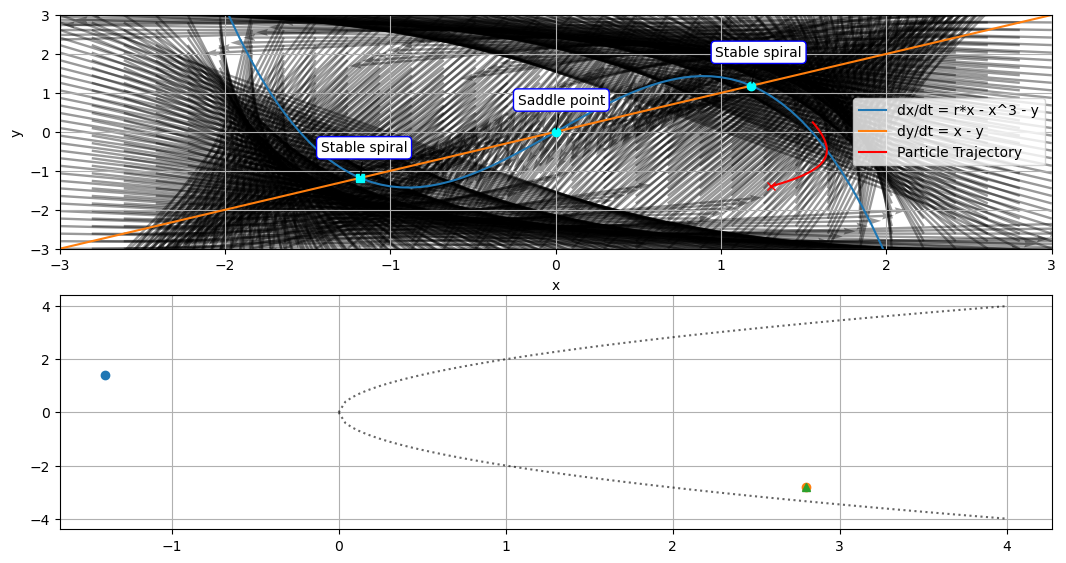

In [26]:
# tkinter app
root = tk.Tk()
root.title("Phase Portrait App")

# Define the frame to embed the plot
frame = tk.Frame(root)
frame.pack(side=tk.TOP, fill=tk.BOTH, expand=True)

# Define the plot
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(8, 6))
canvas = FigureCanvasTkAgg(fig, master=frame)
canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)

# Define tkinter Scale widgets for parameters
zoom_scale = tk.Scale(root, from_=0.1, to=3, resolution=0.1, orient=tk.HORIZONTAL, label='Zoom:')
arrow_flow_scale = tk.Scale(root, from_=5, to=50, resolution=1, orient=tk.HORIZONTAL, label='Arrow Flow:')
r_scale = tk.Scale(root, from_=0.1, to=10, resolution=0.1, orient=tk.HORIZONTAL, label='r:')
time_span_scale = tk.Scale(root, from_=0.1, to=5, resolution=0.1, orient=tk.HORIZONTAL, label='Time Span:')
x_start_scale = tk.Scale(root, from_=-3, to=3, resolution=0.1, orient=tk.HORIZONTAL, label='x Start:')
y_start_scale = tk.Scale(root, from_=-3, to=3, resolution=0.1, orient=tk.HORIZONTAL, label='y Start:')
custom_t_toggle = tk.Checkbutton(root, text="Use Custom t", variable=tk.BooleanVar(), onvalue=True, offvalue=False)
t_param_scale = tk.Scale(root, from_=0.1, to=5, resolution=0.1, orient=tk.HORIZONTAL, label='t Parameter:', state='disabled')

# Update state of t_param_scale based on custom_t_toggle
def update_t_param_slider():
    if custom_t_toggle.var.get():
        t_param_scale.configure(state='normal')
    else:
        t_param_scale.configure(state='disabled')

custom_t_toggle.config(command=update_t_param_slider)

# Position the widgets
widgets = [
    (zoom_scale, 0), (arrow_flow_scale, 1), (r_scale, 2),
    (time_span_scale, 3), (x_start_scale, 4), (y_start_scale, 5),
    (custom_t_toggle, 6), (t_param_scale, 7)
]

for widget, row in widgets:
    widget.pack(side = tk.LEFT, padx=5, pady=5)

# Function to update the plot
def update_plot(event=None):
    plot_phase_portrait(axs, zoom_val=zoom_scale.get(), arrow_flow=arrow_flow_scale.get(),
                        r=r_scale.get(), time_span=time_span_scale.get(), x_start=x_start_scale.get(),
                        y_start=y_start_scale.get(), use_custom_t=False,#custom_t_toggle['variable'].get(),
                        t_param=t_param_scale.get())
    canvas.draw()

# Bind scale changes to update_plot function
for widget, _ in widgets:
    widget.bind("<Motion>", update_plot)

# Initial plot
update_plot()

# Start the tkinter event loop
root.mainloop()